In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00


In [2]:
# main.py
# Implementation of Neural Machine Translation in pytorch.
# Dataset: https://huggingface.co/datasets/ted_hrlr
# (https://huggingface.co/datasets/ted_hrlr/viewer/pt_to_en)


from __future__ import unicode_literals, print_function, division
from io import open
import json
import logging
import math
import random
import re
import time
import unicodedata

from datasets import load_dataset
import transformers
from transformers import AutoTokenizer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import Dataset, dataloader

In [3]:
# Set device.
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
if torch.backends.mps.is_available():
    device = "mps"
print(f"Compute Device chosen: {device}")

Compute Device chosen: cuda


In [4]:
# Load the data.
data = load_dataset("ted_hrlr", "pt_to_en")
train_examples, val_examples = data["train"], data["validation"]
# print(train_examples)
# print(train_examples["translation"])
print("Translations:")
print(json.dumps(train_examples["translation"][:3], indent=4))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1194 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1804 [00:00<?, ? examples/s]

Translations:
[
    {
        "en": "amongst all the troubling deficits we struggle with today \u2014 we think of financial and economic primarily \u2014 the ones that concern me most is the deficit of political dialogue \u2014 our ability to address modern conflicts as they are , to go to the source of what they 're all about and to understand the key players and to deal with them .",
        "pt": "entre todas as grandes priva\u00e7\u00f5es com que nos debatemos hoje \u2014 pensamos em financeiras e econ\u00f3micas primeiro \u2014 aquela que mais me preocupa \u00e9 a falta de di\u00e1logo pol\u00edtico \u2014 a nossa capacidade de abordar conflitos modernos como eles s\u00e3o , de ir \u00e0 raiz do que eles s\u00e3o e perceber os agentes-chave e lidar com eles ."
    },
    {
        "en": "we who are diplomats , we are trained to deal with conflicts between states and issues between states .",
        "pt": "n\u00f3s que somos diplomatas , somos treinados para lidar com conflitos en

In [5]:
# Original example used a pretrained tensorflow subword tokenizer. It
# is not possible to convert this tokenizer to pytorch quickly. I was
# going to use the tokenizer devised in this pytorch example/tutorial:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# however, this was primarily for the english to french translation
# dataset (provided in that pytorch example) and didnt have the
# necessary data for english to portuguese translation done in the
# tensorflow example. I decided to use this multilingual tokenizer for
# BERT multilingual base cased (thank you Google):
# https://huggingface.co/google-bert/bert-base-multilingual-cased
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [6]:
# Test tokenizer.
samples = train_examples["translation"][:3]
en_pt = [(sample["en"], sample["pt"]) for sample in samples]
en = [sample[0] for sample in en_pt]
pt = [sample[1] for sample in en_pt]
print("> English:")
print(f"{en[0]}")
print("> English tokenized:")
print(tokenizer.encode(en[0]))
print("> Portuguese:")
print(f"{pt[0]}")
print("> Portuguese tokenized:")
print(tokenizer.encode(pt[0]))

> English:
amongst all the troubling deficits we struggle with today — we think of financial and economic primarily — the ones that concern me most is the deficit of political dialogue — our ability to address modern conflicts as they are , to go to the source of what they 're all about and to understand the key players and to deal with them .
> English tokenized:
[101, 48593, 10435, 10105, 42169, 20664, 11945, 107383, 10107, 11951, 48919, 10169, 18745, 100, 11951, 27874, 10108, 20570, 10111, 13925, 22426, 100, 10105, 35688, 10189, 43607, 10911, 10992, 10124, 10105, 107383, 10108, 13736, 51077, 100, 17446, 23599, 10114, 32198, 13456, 83594, 10146, 10689, 10301, 117, 10114, 11783, 10114, 10105, 15247, 10108, 12976, 10689, 112, 11639, 10435, 10978, 10111, 10114, 49151, 10105, 18444, 16021, 10111, 10114, 19918, 10169, 11345, 119, 102]
> Portuguese:
entre todas as grandes privações com que nos debatemos hoje — pensamos em financeiras e económicas primeiro — aquela que mais me preocupa é a 

In [7]:
# Use pytorch dataset to do the translation.
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_tokens):
        super().__init__()
        self.dataset = hf_dataset["translation"]
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Tokenize the texts. Dont forget to pad and truncate to
        # MAX_TOKENS. Reference guide here:
        # https://huggingface.co/docs/transformers/en/pad_truncation
        en_tokens = tokenizer.encode(
            sample["en"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )
        pt_tokens = tokenizer.encode(
            sample["pt"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "en_inputs": en_tokens[:, :-1],
            "en_labels": en_tokens[:, 1:],
            "pt": pt_tokens
        }


In [8]:
# Pass the huggingface dataset through the custom dataset subclass for
# each split.
MAX_TOKENS = 128
train_set = TranslationDataset(train_examples, tokenizer, MAX_TOKENS)
valid_set = TranslationDataset(val_examples, tokenizer, MAX_TOKENS)


In [9]:
# Batch the dataset with a dataloader.
BATCH_SIZE = 8#64
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [10]:
# Test dataset.
train_features = next(iter(train_loader))
print(f"> inputs")
print(train_features["en_inputs"])
print(train_features["pt"])
print(f"> outputs")
print(train_features["en_labels"])

> inputs
tensor([[[  101, 11155,   112,  ...,     0,     0,     0]],

        [[  101, 10111, 10689,  ...,     0,     0,     0]],

        [[  101, 10473, 10106,  ...,     0,     0,     0]],

        ...,

        [[  101,   177, 24666,  ...,     0,     0,     0]],

        [[  101, 10111, 11951,  ...,     0,     0,     0]],

        [[  101, 10111, 10689,  ...,     0,     0,     0]]])
tensor([[[  101, 68594, 17339,  ...,     0,     0,     0]],

        [[  101, 19695, 70218,  ...,     0,     0,     0]],

        [[  101, 10220, 11419,  ...,     0,     0,     0]],

        ...,

        [[  101, 14541, 10116,  ...,     0,     0,     0]],

        [[  101,   173, 10321,  ...,     0,     0,     0]],

        [[  101,   173, 33387,  ...,     0,     0,     0]]])
> outputs
tensor([[[11155,   112,   187,  ...,     0,     0,     0]],

        [[10111, 10689, 27156,  ...,     0,     0,     0]],

        [[10473, 10106, 12990,  ...,     0,     0,     0]],

        ...,

        [[  177, 24666, 

In [11]:
# MultiHeadAttention.
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation


    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output


    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)


    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [12]:
# Point-wise Feed Forward Network.
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()


    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [13]:
# Positional Encoding.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))


    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [14]:
# Encoder Layer.
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [15]:
# Decoder Layer.
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [16]:
# Transformer.
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        nopeak_mask = nopeak_mask.to(tgt_mask.device) # Code added by me. Had to add device logic so all tensors went to same device.
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask


    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [17]:
# Hyperparameters.
src_vocab_size = tokenizer.vocab_size
tgt_vocab_size = tokenizer.vocab_size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
# max_seq_length = 100
max_seq_length = MAX_TOKENS
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)


In [18]:
# Initialize Transformer model.
transformer = Transformer(
    src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout
)
transformer.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [19]:
import os
import torch

checkpoint_dir = "/content/checkpoints/"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_files = [file for file in os.listdir(checkpoint_dir) if file.endswith('.pt')]

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files)

    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    checkpoint = torch.load(latest_checkpoint_path)

    start_epoch = checkpoint['epoch'] + 1
    transformer.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

    print(f"Loading latest checkpoint: {latest_checkpoint_path}")
    print(f"Starting training from epoch {start_epoch}, Loss: {loss}")
else:
    print("No checkpoint files found in the directory.")
    start_epoch = 0  # start_epoch when no checkpoint files are found


No checkpoint files found in the directory.


In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(transformer)
print(f"Total trainable parameters in the model: {total_params}")

transformer.train()

for epoch in range(start_epoch, 100):
    start_time = time.time()
    loss_total = 0
    counter = 0
    for i, data in enumerate(train_loader):
        src_data = data["pt"]
        tgt_data = data["en_labels"]
        tgt_input = data["en_inputs"]

        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)
        tgt_input = tgt_input.to(device)

        src_data = src_data.squeeze(1)
        tgt_data = tgt_data.squeeze(1)
        tgt_input = tgt_input.squeeze(1)

        optimizer.zero_grad()

        output = transformer(src_data, tgt_input)
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data.contiguous().view(-1))
        loss.backward()
        loss_total += loss.item()
        counter += 1
        optimizer.step()

    loss = loss_total / counter

    end_time = time.time()
    epoch_time = end_time - start_time

    mem_usage = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert bytes to MB

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt"))

    print(f"Epoch: {epoch+1}, Loss: {loss}, Time per Epoch: {epoch_time} sec, Memory Usage: {mem_usage:.2f} MB")

# Model evaluation.
transformer.eval()



Total trainable parameters in the model: 227882235
Epoch: 1, Loss: 4.644525063711808, Time per Epoch: 1742.0845878124237 sec, Memory Usage: 3615.70 MB
Epoch: 2, Loss: 3.577186105812557, Time per Epoch: 1742.7883784770966 sec, Memory Usage: 4079.72 MB


Transformer(
  (encoder_embedding): Embedding(119547, 512)
  (decoder_embedding): Embedding(119547, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLaye

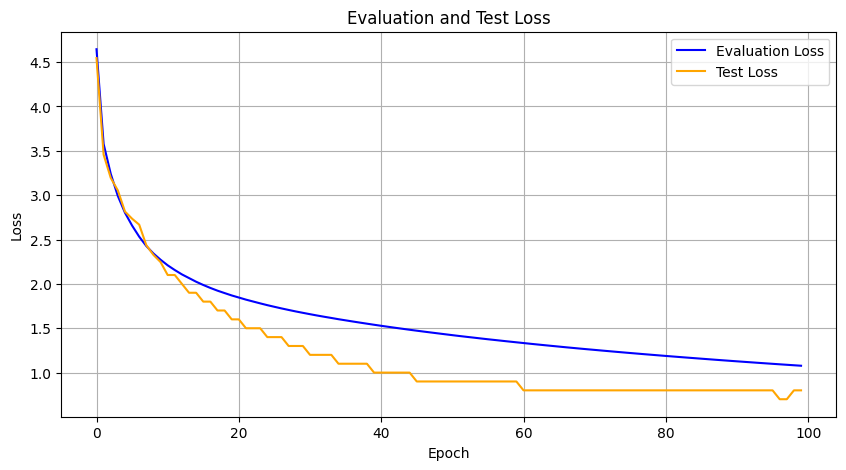

In [8]:
import matplotlib.pyplot as plt

# Data got from training the model
eval_losses = [
    4.6445250637118084, 3.5771861054812557, 3.2405248951639826, 2.9897712013953276, 2.8016729436276457,
    2.6571128139567784, 2.5317893462380953, 2.4263225709681841, 2.3425057649190383, 2.2720846798246233,
    2.2092375362838834, 2.1559073951181963, 2.1068314096824982, 2.0653978803528564, 2.0239937132042237,
    1.9875172639298746, 1.9541738327827914, 1.9234685216193037, 1.8961764959346747, 1.6951893728354826,
    1.8460557247781815, 1.8224041667924218, 1.8012843934478265, 1.7803002817447578, 1.7601053016657445,
    1.7415319846925133, 1.7232451764592327, 1.7059987116482536, 1.6892624862377655, 1.6736847552021142,
    1.6582854201037276, 1.6434609352380834, 1.6293083795518765, 1.6157740600386503, 1.6017614330273496,
    1.5890120392861746, 1.5761283957010276, 1.5636373924919484, 1.5513947242208964, 1.5392508933571853,
    1.5274499036540792, 1.5161242377686703, 1.5048217025163697, 1.4938296093124756, 1.4828862950028345,
    1.4723796479826125, 1.4620114057196898, 1.4519409234376522, 1.4418920904528367, 1.4319781748382395,
    1.4220740915509115, 1.4123892437816128, 1.4031468218288824, 1.3941272683703037, 1.3848191123039756,
    1.3757449269018586, 1.3671954749247382, 1.3584420033675868, 1.3498637194720493, 1.3414592809108323,
    1.3330957158102275, 1.3247389027456097, 1.3165752482680338, 1.3086063480342055, 1.3007610147320615,
    1.2929640036302228, 1.2851273940519984, 1.2776779413548946, 1.2701375246385392, 1.2629126739260437,
    1.2558264335896472, 1.2485706242824635, 1.2415378641329598, 1.2344863082026837, 1.2275994328593267,
    1.2207751392654364, 1.2140477125734823, 1.2073356821017264, 1.2007908564318947, 1.1942916802285934,
    1.1878017265128823, 1.1814600383937492, 1.1751975324829303, 1.1689807529903176, 1.1628976138729534,
    1.1567295286294428, 1.1506842827623725, 1.1446478308426823, 1.1387229487365947, 1.1328793846102736,
    1.1271264172376814, 1.1213749201318796, 1.1156965118477233, 1.1100476832746853, 1.1045115266830728,
    1.0989832650142953, 1.0935178320285596, 1.0881144207427225, 1.0827926388213344, 1.0774631288396553
]

test_losses = [
    4.6553647294036273, 3.5872447697956352, 3.2546733895395754, 3.0097452834910463, 2.8193758394527433,
    2.6665879562840173, 2.5452534295473842, 2.4304748293046375, 2.3554537283920361, 2.2857355835957435,
    2.2098120348573626, 2.1498568923682715, 2.1002374805938472, 2.0796324518901723, 2.0388365239876123,
    1.9975143218759361, 1.9742642387612432, 1.9410314795673811, 1.9114302158375365, 1.8894327364981746,
    1.8554257907582736, 1.8254329812865114, 1.7923750284036114, 1.7775349205718632, 1.7554289357298462,
    1.7358120475948245, 1.7267935486032947, 1.7074865873571984, 1.6888045214562903, 1.6701504687236151,
    1.6607529349824612, 1.6427549360157326, 1.6275938417283574, 1.6123984518474913, 1.5982543368491406,
    1.5831379836289648, 1.5694294484059263, 1.5561265924857624, 1.5431796036832746, 1.5307924389235948,
    1.5186753750836134, 1.5073125871429637, 1.4963274283284993, 1.4852264834287383, 1.4740925342916598,
    1.4638924438927202, 1.4537482489644911, 1.4433792672835049, 1.4334521268492483, 1.4234636847857225,
    1.4134494826291314, 1.4034578847564912, 1.3933559864901955, 1.3831246872901639, 1.3727954103647819,
    1.3625443015987451, 1.3524653037486432, 1.3425074982674722, 1.3326224896829243, 1.3226600253820483,
    1.3127432895196459, 1.3027865620349181, 1.2928793428592641, 1.2829961512975438, 1.2730376285492647,
    1.2630215849201836, 1.2530569128901849, 1.2430814561202179, 1.2330372518931574, 1.2230667527483277,
    1.2130482694383627, 1.2031087245789453, 1.1931528327486215, 1.1832675827492471, 1.1733232945283214,
    1.1633847926402918, 1.1533989815236714, 1.1434562884172034, 1.1335832574923816, 1.1236472357283873,
    1.1137402543784213, 1.1038315035773716, 1.0939472153021849, 1.0840481126949361, 1.0741422794257872,
    1.0642372158361935, 1.0543258128935277, 1.0444471264828234, 1.0345563781359835, 1.0246700318745411,
    1.0147862347231742, 1.0049365226187926, 0.9950851437826723, 0.9852853402198465, 0.9754223930246983,
    0.9655763128692137, 0.9557148274468926, 0.9458734117374054, 0.9360412761467824, 0.9261932765712348
]

# Plot evaluation loss and test loss
plt.figure(figsize=(10, 5))
plt.plot(eval_losses, label='Evaluation Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

